# CIFAR10: Image classification using ResNet

In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
if not os.path.isfile('dataset/cifar10.tgz'):
    dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
    download_url(dataset_url, 'dataset/')
else:
    print('Data already downloaded.')

if not os.path.isdir('dataset/cifar10'):
    with tarfile.open('dataset/cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='dataset/')
else:
    print('Data already extracted.')

data_dir = 'dataset/cifar10/'
print(os.listdir(data_dir))

classes = os.listdir(data_dir + 'train')
print(classes)

Data already downloaded.
Data already extracted.
['labels.txt', 'models', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [3]:
# imgs = []
# for d in os.listdir(data_dir + 'train'):
#     for fname in os.listdir(data_dir + 'train/' + d):
#         img = Image.open(data_dir + 'train/' + d + '/' + fname)
#         img_arr = np.array(img) / 255.
#         imgs.append(img_arr)
#
# imgs = np.stack(imgs)
# reds, greens, blues = imgs[:, :, :, 0], imgs[:, :, :, 1], imgs[:, :, :, 2]
# means = [np.mean(reds), np.mean(greens), np.mean(blues)]
# std = [np.std(reds), np.std(greens), np.std(blues)]
# means, std

In [4]:
torch.cuda.empty_cache() 

### Data Augmentation and Normalisation

In [5]:
means, std = ([0.4913996786151959, 0.4821584083946092, 0.4465309144454658], [0.2470322324632819, 0.24348512800005603, 0.26158784172796434])

In [6]:
train_tfms = tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(means, std)
])

val_tfms = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(means, std)
])

In [7]:
train_ds = ImageFolder(data_dir + 'train', train_tfms)
val_ds = ImageFolder(data_dir + 'test', val_tfms)

In [8]:
batch_size = 64

In [9]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)

In [10]:
def show_batch(dl):
    global fig, ax
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
        return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


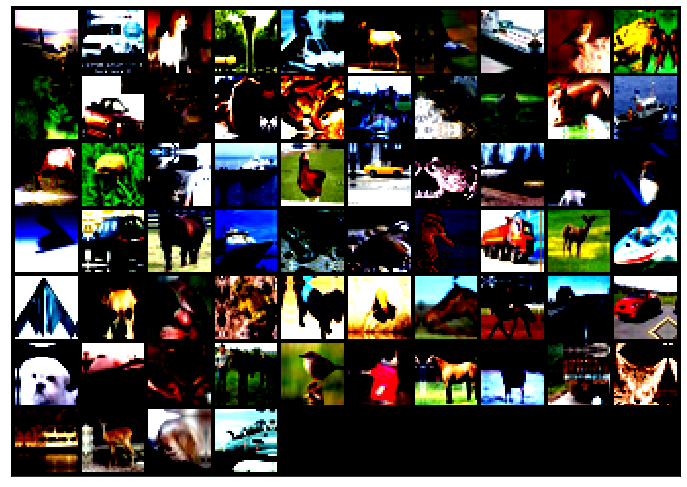

In [11]:
show_batch(train_loader)

### Using Residual Block

Residual block = x -> Conv Layer -> Relu -> Conv Layer -> + x -> Relu

In [12]:
class SimpleResidualNetwork (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out + x)

In [13]:
simple_renet = SimpleResidualNetwork()

In [14]:
for images, labels in train_loader:
    out = simple_renet(images)
    print('out.shape', out.shape)
    break

out.shape torch.Size([64, 3, 32, 32])


### Batch Normalisation

Take the output at the end of a block and normalise it across dimensions

In [15]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, stride=stride, kernel_size=ks, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(
        nn.BatchNorm2d(ni),
        nn.ReLU(inplace=True),
        conv_2d(ni, nf)
    )

class ResidualBlock (nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride=stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride=stride, ks=1)

    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [16]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride=stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class FlattenLayer (nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet (nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()
        
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        for i in range(n_groups):
            n_channels.append(n_start * (2**i) * k)
            stride = 2 if i > 0 else 1
            layers += make_group(N, n_channels[i], n_channels[i + 1], stride)
        
        layers += [
            nn.BatchNorm2d(n_channels[-1]),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            FlattenLayer(),
            nn.Linear(n_channels[-1], n_classes)
        ]

        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)

def wrn_22():
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [17]:
model = wrn_22()

In [18]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [19]:
for images, labels in train_loader:
    print('input.shape', images.shape)
    out = model(images)
    print('out.shape', out.shape)
    break

input.shape torch.Size([64, 3, 32, 32])
out.shape torch.Size([64, 10])


In [20]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [21]:
data = DataBunch.create(train_ds, val_ds, bs=batch_size, path=data_dir)
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

In [22]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


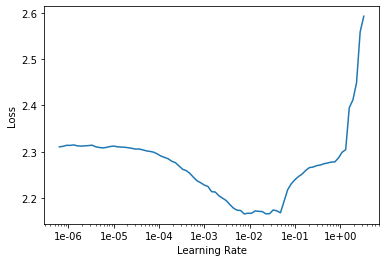

In [23]:
learner.recorder.plot()

In [24]:
learner.fit_one_cycle(10, 5e-3, wd=1e-4) #wd is weight decay

epoch,train_loss,valid_loss,accuracy,time
0,1.107903,1.556908,0.508300,03:43
1,0.923825,0.889067,0.696200,03:40
2,0.668029,0.760317,0.740900,03:20
3,0.564398,0.521009,0.815300,03:05
4,0.451934,0.462949,0.841500,03:11
5,0.359107,0.357928,0.878800,03:11
6,0.267320,0.331854,0.891400,03:11
7,0.213508,0.268796,0.911900,03:10
8,0.172416,0.260269,0.915000,03:07
9,0.149295,0.255756,0.918100,03:06


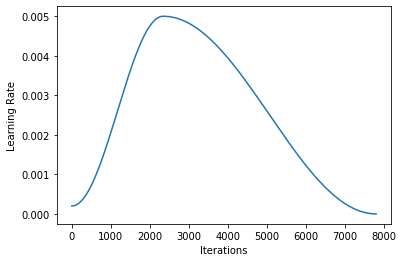

In [25]:
learner.recorder.plot_lr()

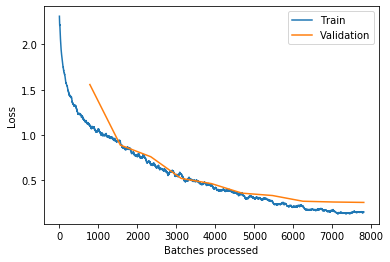

In [26]:
learner.recorder.plot_losses()

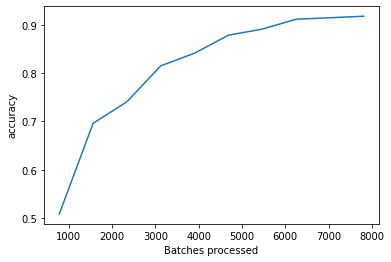

In [27]:
learner.recorder.plot_metrics()

In [28]:
torch.save(model.state_dict(), 'models/cifar10-wrn22.pth')